In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
league_list = pd.read_csv('league_lookups.csv')

In [3]:
league_list

,Country Code,Country Name,League Name,League Code
0,EN,England,Premier League,E0
1,SC,Scotland,Scottish Premier League,SC0
2,DE,Germany,Bundesliga,D1
3,IT,Italy,Serie A,I1
4,ES,Spain,Primera Division,SP1
5,FR,France,Ligue A,F1
6,NL,Netherlands,Eredevisie,N1
7,BE,Belgium,Jupiler League,B1
8,PT,Portugal,Liga I,P1
9,GR,Greece,Superleague,G1


In [4]:
data_url = 'https://www.football-data.co.uk/mmz4281/'

Download and store historical data: 

In [5]:
start_season = '2009-2010'

current_year = pd.to_datetime('today').year
current_month = pd.to_datetime('today').month
current_season = str(current_year) + '-' + str(current_year+1) if current_month > 6 else str(current_year-1) + '-' + str(current_year) 

seasons = [start_season]
for i in range(0,int(current_season[:4])-int(start_season[:4])):
    seasons.append(str(int(start_season[:4])+(i+1)) + '-' + str(int(start_season[:4])+(i+2)))

seasons                  

['2009-2010',
 '2010-2011',
 '2011-2012',
 '2012-2013',
 '2013-2014',
 '2014-2015',
 '2015-2016',
 '2016-2017',
 '2017-2018',
 '2018-2019',
 '2019-2020',
 '2020-2021',
 '2021-2022']

In [ ]:
data = pd.DataFrame()
for season in seasons:
    season_code = season[2:4]+season[7:9]
    for league_code in league_list['League Code']:
        csv_url = data_url+season_code+'/'+league_code+'.csv'
        data_season_league = pd.read_csv(csv_url, encoding='iso-8859-1')
        data_season_league['Season'] = season_code
        data = data.append(data_season_league)
        
data.insert(0, "Season", data.pop('Season'))

data_historical = data[~pd.isna(data['FTR'])]
data_historical = data_historical.loc[:,~data_historical.columns.str.contains('^Unnamed')]

data_historical.to_csv('data_historical.csv',index=False)

Download latest data:

In [9]:
current_year = pd.to_datetime('today').year
current_month = pd.to_datetime('today').month
current_season = str(current_year) + '-' + str(current_year+1) if current_month > 6 else str(current_year-1) + '-' + str(current_year) 

In [10]:
latest_data = pd.DataFrame()

season_code = current_season[2:4]+current_season[7:9]
for league_code in league_list['League Code']:
    csv_url = data_url+season_code+'/'+league_code+'.csv'
    data_season_league = pd.read_csv(csv_url, encoding='iso-8859-1')
    data_season_league['Season'] = season_code
    latest_data = latest_data.append(data_season_league)

latest_data.insert(0, "Season", latest_data.pop('Season'))

new_fixtures = latest_data[pd.isna(latest_data['FTR'])].dropna()
print('{} upcoming fixtures found.'.format(len(new_fixtures)))

# Add latest historical datat o existing historical data
latest_historical = latest_data[~pd.isna(latest_data['FTR'])]
data_historical = pd.read_csv('data_historical.csv')
prev_records = len(data_historical)
data_historical = data_historical.append(latest_historical).drop_duplicates(subset=['Date','HomeTeam','AwayTeam'])
new_records = len(data_historical)
print('{} records added.'.format(new_records-prev_records))
data_historical.to_csv('data_historical.csv',index=False)

0 upcoming fixtures found.


C:\Users\akapelet\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (66,80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


0 records added.


In [11]:
data_historical.tail()

,Season,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Unnamed: 105
38697,2122,I1,06/12/2021,Empoli,Udinese,3.0,1.0,H,0.0,1.0,...,-0.25,2.00,1.90,1.98,1.94,2.05,1.95,1.99,1.87,NaN
38698,2122,I1,06/12/2021,Cagliari,Torino,1.0,1.0,D,0.0,1.0,...,0.25,1.85,2.05,1.92,2.01,1.96,2.06,1.87,2.01,NaN
38699,2122,SP1,06/12/2021,Getafe,Ath Bilbao,0.0,0.0,D,0.0,0.0,...,0.25,1.86,2.04,1.87,2.06,1.97,2.07,1.86,2.01,NaN
38700,2122,G1,06/12/2021,Lamia,Giannina,0.0,1.0,A,0.0,0.0,...,0.25,1.90,1.95,1.87,1.99,1.95,2.10,1.85,1.95,NaN
38701,2122,SC0,08/12/2021,Livingston,Hibernian,1.0,0.0,H,1.0,0.0,...,0.25,2.02,1.77,2.09,1.83,2.16,1.84,2.06,1.78,NaN


In [12]:
data_historical = data_historical.append(new_fixtures) # add new fixtures at the bottom of the historical table so that pre-match statistics are also calculated for the new fixtures 

### Calculate prediction features

In [21]:
data_historical = pd.read_csv('data_historical.csv')

In [22]:
data_historical['Date'] = data_historical['Date'].apply(lambda x: x[:x.rfind('/')+1] + '20' + x[x.rfind('/')+1:] if len(x[x.rfind('/')+1:])==2 else x) 
data_historical['Date'] = pd.to_datetime(data_historical['Date'],format='%d/%m/%Y')

Points, Goals before each match:

In [23]:
# Match points
data_historical['H_Match_Points'] = data_historical['FTR'].apply(lambda x: 3 if x=='H' else 1 if x=='D' else 0) 
data_historical['A_Match_Points'] = data_historical['FTR'].apply(lambda x: 3 if x=='A' else 1 if x=='D' else 0)

In [24]:
# Points before match
data_historical = data_historical.sort_values(by='Date')
H_team_stats = data_historical[['HomeTeam','Season','Div','Date','AwayTeam','H_Match_Points','FTHG','FTAG']]
H_team_stats = H_team_stats.rename(columns={'HomeTeam':'Team', 'AwayTeam':'Opponent'})

H_team_stats['H/A'] = 'H'

H_team_stats['H_Points_Season'] = H_team_stats.groupby(['Team','Season'])['H_Match_Points'].cumsum()
H_team_stats['H_Points_Pre_Match_Season'] = H_team_stats['H_Points_Season']-H_team_stats['H_Match_Points']

H_team_stats['H_Points'] = H_team_stats.groupby(['Team'])['H_Match_Points'].cumsum()
H_team_stats['H_Points_Pre_Match'] = H_team_stats['H_Points']-H_team_stats['H_Match_Points']

H_team_stats['Goals_Scored'] = H_team_stats['FTHG']
H_team_stats['Goals_Conceded'] = H_team_stats['FTAG']

H_team_stats['H_Goals_Scored'] = H_team_stats.groupby(['Team','Season'])['FTHG'].cumsum()
H_team_stats['H_Goals_Conceded'] = H_team_stats.groupby(['Team','Season'])['FTAG'].cumsum()

H_team_stats['N_Home_Matches'] = H_team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [25]:
A_team_stats = data_historical[['AwayTeam','Season','Div','Date','HomeTeam','A_Match_Points','FTHG','FTAG']]
A_team_stats = A_team_stats.rename(columns={'AwayTeam':'Team', 'HomeTeam':'Opponent'})

A_team_stats['H/A'] = 'A'

A_team_stats['A_Points_Season'] = A_team_stats.groupby(['Team','Season'])['A_Match_Points'].cumsum()
A_team_stats['A_Points_Pre_Match_Season'] = A_team_stats['A_Points_Season']-A_team_stats['A_Match_Points']

A_team_stats['A_Points'] = A_team_stats.groupby(['Team'])['A_Match_Points'].cumsum()
A_team_stats['A_Points_Pre_Match'] = A_team_stats['A_Points']-A_team_stats['A_Match_Points']

A_team_stats['Goals_Scored'] = A_team_stats['FTAG']
A_team_stats['Goals_Conceded'] = A_team_stats['FTHG']

A_team_stats['A_Goals_Scored'] = A_team_stats.groupby(['Team','Season'])['FTAG'].cumsum()
A_team_stats['A_Goals_Conceded'] = A_team_stats.groupby(['Team','Season'])['FTHG'].cumsum()

A_team_stats['N_Away_Matches'] = A_team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [26]:
team_stats = H_team_stats.append(A_team_stats)

In [27]:
team_stats['Match_Points'] = team_stats['H_Match_Points'].fillna(0) + team_stats['A_Match_Points'].fillna(0)

In [28]:
team_stats = team_stats.sort_values(by='Date')

team_stats['Total_Points_Season'] = team_stats.groupby(['Team','Season'])['Match_Points'].cumsum()
team_stats['Total_Points_Pre_Match_Season'] = team_stats['Total_Points_Season'] - team_stats['Match_Points']

team_stats['Total_Points'] = team_stats.groupby(['Team'])['Match_Points'].cumsum()
team_stats['Total_Points_Pre_Match'] = team_stats['Total_Points'] - team_stats['Match_Points']

team_stats['Total_Goals_Scored'] = team_stats.groupby(['Team','Season'])['Goals_Scored'].cumsum()
team_stats['Total_Goals_Conceded'] = team_stats.groupby(['Team','Season'])['Goals_Conceded'].cumsum()

team_stats['Total_Goals_Scored_Pre_Match'] = team_stats.groupby(['Team','Season'])['Goals_Scored'].cumsum() - team_stats['Goals_Scored']
team_stats['Total_Goals_Conceded_Pre_Match'] = team_stats.groupby(['Team','Season'])['Goals_Conceded'].cumsum() - team_stats['Goals_Conceded']

team_stats['N_Matches_Season'] = team_stats.groupby(['Team','Season'])['Team'].cumcount() + 1
team_stats['N_Matches'] = team_stats.groupby(['Team'])['Team'].cumcount() + 1

In [29]:
team_stats[(team_stats['Team']=='Olympiakos')&(team_stats['Season']==2122)].to_csv('check1.csv',index=False)
team_stats[(team_stats['Team']=='Olympiakos')&(team_stats['Season']==2122)]

,Team,Season,Div,Date,Opponent,H_Match_Points,FTHG,FTAG,H/A,H_Points_Season,...,Total_Points_Season,Total_Points_Pre_Match_Season,Total_Points,Total_Points_Pre_Match,Total_Goals_Scored,Total_Goals_Conceded,Total_Goals_Scored_Pre_Match,Total_Goals_Conceded_Pre_Match,N_Matches_Season,N_Matches
38353,Olympiakos,2122,G1,2021-09-12,Atromitos,1.0,0.0,0.0,H,1.0,...,1.0,0.0,917.0,916.0,0.0,0.0,0.0,0.0,1,380
38361,Olympiakos,2122,G1,2021-09-19,Lamia,NaN,1.0,2.0,A,NaN,...,4.0,1.0,920.0,917.0,2.0,1.0,0.0,0.0,2,381
38363,Olympiakos,2122,G1,2021-09-22,Apollon,3.0,4.0,1.0,H,4.0,...,7.0,4.0,923.0,920.0,6.0,2.0,2.0,1.0,3,382
38369,Olympiakos,2122,G1,2021-09-26,Asteras Tripolis,NaN,0.0,2.0,A,NaN,...,10.0,7.0,926.0,923.0,8.0,2.0,6.0,2.0,4,383
38382,Olympiakos,2122,G1,2021-10-03,Panathinaikos,1.0,0.0,0.0,H,5.0,...,11.0,10.0,927.0,926.0,8.0,2.0,8.0,2.0,5,384
38388,Olympiakos,2122,G1,2021-10-17,Giannina,NaN,1.0,2.0,A,NaN,...,14.0,11.0,930.0,927.0,10.0,3.0,8.0,2.0,6,385
38396,Olympiakos,2122,G1,2021-10-24,PAOK,3.0,2.0,1.0,H,8.0,...,17.0,14.0,933.0,930.0,12.0,4.0,10.0,3.0,7,386
38397,Olympiakos,2122,G1,2021-10-30,Panetolikos,NaN,1.0,2.0,A,NaN,...,20.0,17.0,936.0,933.0,14.0,5.0,12.0,4.0,8,387
38409,Olympiakos,2122,G1,2021-11-07,Ionikos,3.0,1.0,0.0,H,11.0,...,23.0,20.0,939.0,936.0,15.0,5.0,14.0,5.0,9,388
38680,Olympiakos,2122,G1,2021-11-21,AEK,NaN,2.0,3.0,A,NaN,...,26.0,23.0,942.0,939.0,18.0,7.0,15.0,5.0,10,389


In [30]:
# Points won on last n games (H/A and total)
def calc_last_games_points(stats, n_last, index_columns):
    
    n_last_str = str(n_last)
    
    # Last n Home game
    stats['N_Home_Matches_PLUS_' + n_last_str] = stats['N_Home_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Home_Matches'].notna()][index_columns + ['N_Home_Matches_PLUS_' + n_last_str,'H_Points_Pre_Match']].rename(columns={'H_Points_Pre_Match':'H_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Home_Matches'],right_on=index_columns+['N_Home_Matches_PLUS_' + n_last_str], how='left')
    stats['H_Points_Pre_' + n_last_str] = stats['H_Points_Pre_Match']-stats['H_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str + '_H'] = stats['H_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Home_Matches_PLUS_' + n_last_str + '_x','N_Home_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()

    # Last n Away game
    stats['N_Away_Matches_PLUS_' + n_last_str] = stats['N_Away_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Away_Matches'].notna()][index_columns+['N_Away_Matches_PLUS_' + n_last_str,'A_Points_Pre_Match']].rename(columns={'A_Points_Pre_Match':'A_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Away_Matches'],right_on=index_columns+['N_Away_Matches_PLUS_' + n_last_str], how='left')
    stats['A_Points_Pre_' + n_last_str] = stats['A_Points_Pre_Match']-stats['A_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str + '_A'] = stats['A_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Away_Matches_PLUS_' + n_last_str + '_x','N_Away_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()

    # Last n games (Home or Away)
    stats['N_Matches_PLUS_' + n_last_str] = stats['N_Matches'] + n_last
    stats = stats.merge(stats[stats['N_Matches'].notna()][index_columns+['N_Matches_PLUS_' + n_last_str,'Total_Points_Pre_Match']].rename(columns={'Total_Points_Pre_Match':'Total_Points_Pre_' + n_last_str}),left_on=index_columns+['N_Matches'],right_on=index_columns+['N_Matches_PLUS_' + n_last_str], how='left')
    stats['Total_Points_Pre_' + n_last_str] = stats['Total_Points_Pre_Match']-stats['Total_Points_Pre_' + n_last_str]
    stats['Last_'+ n_last_str] = stats['Total_Points_Pre_'+ n_last_str] / (3*n_last)
    stats = stats.drop(columns=['N_Matches_PLUS_' + n_last_str + '_x','N_Matches_PLUS_' + n_last_str + '_y'])
    stats = stats.drop_duplicates()
    
    return stats

In [31]:
index_columns = ['Team']
team_stats = calc_last_games_points(team_stats, n_last = 1, index_columns = index_columns)
team_stats = calc_last_games_points(team_stats, n_last = 3, index_columns = index_columns)
team_stats = calc_last_games_points(team_stats, n_last = 5, index_columns = index_columns)

In [32]:
print('Last 1 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_1_H'].min(),team_stats['Last_1_H'].max()))
print('Last 1 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_1_A'].min(),team_stats['Last_1_A'].max()))
print('Last 1 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_1'].min(),team_stats['Last_1'].max()))

print('Last 3 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_3_H'].min(),team_stats['Last_3_H'].max()))
print('Last 3 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_3_A'].min(),team_stats['Last_3_A'].max()))
print('Last 3 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_3'].min(),team_stats['Last_3'].max()))

print('Last 5 game home points stats -  Min: {}, Max: {}'.format(team_stats['Last_5_H'].min(),team_stats['Last_5_H'].max()))
print('Last 5 game away points stats -  Min: {}, Max: {}'.format(team_stats['Last_5_A'].min(),team_stats['Last_5_A'].max()))
print('Last 5 game total points stats -  Min: {}, Max: {}'.format(team_stats['Last_5'].min(),team_stats['Last_5'].max()))

Last 1 game home points stats -  Min: 0.0, Max: 1.0
Last 1 game away points stats -  Min: 0.0, Max: 1.0
Last 1 game total points stats -  Min: 0.0, Max: 1.0
Last 3 game home points stats -  Min: 0.0, Max: 1.0
Last 3 game away points stats -  Min: 0.0, Max: 1.0
Last 3 game total points stats -  Min: 0.0, Max: 1.0
Last 5 game home points stats -  Min: 0.0, Max: 1.0
Last 5 game away points stats -  Min: 0.0, Max: 1.0
Last 5 game total points stats -  Min: 0.0, Max: 1.0


In [33]:
# For check
team_stats[(team_stats['Div']=='G1')&(team_stats['Season']==2122)].to_csv('test_1.csv',index=False)

History of results between each team pair

In [34]:
opponent_history = team_stats[['Team','Opponent','H/A','Date','H_Match_Points','A_Match_Points','Match_Points']].copy()

In [35]:
opponent_history['N_Home_Matches'] = opponent_history.groupby(['Team','Opponent','H/A']).cumcount()+1
opponent_history.loc[opponent_history['H/A']=='A','N_Home_Matches'] = np.nan
opponent_history['N_Away_Matches'] = opponent_history.groupby(['Team','Opponent','H/A']).cumcount()+1
opponent_history.loc[opponent_history['H/A']=='H','N_Away_Matches'] = np.nan
opponent_history['N_Matches'] = opponent_history.groupby(['Team','Opponent']).cumcount()+1

In [36]:
opponent_history['H_Points'] = opponent_history.groupby(['Team','Opponent','H/A'])['H_Match_Points'].cumsum()
opponent_history['H_Points_Pre_Match'] = opponent_history['H_Points']-opponent_history['H_Match_Points']
opponent_history['A_Points'] = opponent_history.groupby(['Team','Opponent','H/A'])['A_Match_Points'].cumsum()
opponent_history['A_Points_Pre_Match'] = opponent_history['A_Points']-opponent_history['A_Match_Points']
opponent_history['Total_Points'] = opponent_history.groupby(['Team','Opponent'])['Match_Points'].cumsum()
opponent_history['Total_Points_Pre_Match'] = opponent_history['Total_Points'] - opponent_history['Match_Points']

In [37]:
index_columns = ['Team','Opponent']
opponent_history = calc_last_games_points(opponent_history, n_last = 1, index_columns = index_columns)
opponent_history = calc_last_games_points(opponent_history, n_last = 3, index_columns = index_columns)
opponent_history = calc_last_games_points(opponent_history, n_last = 5, index_columns = index_columns)

In [38]:
opponent_history[(opponent_history['Team']=='Olympiakos')&(opponent_history['Opponent']=='AEK')]

,Team,Opponent,H/A,Date,H_Match_Points,A_Match_Points,Match_Points,N_Home_Matches,N_Away_Matches,N_Matches,...,A_Points_Pre_3,Last_3_A,Total_Points_Pre_3,Last_3,H_Points_Pre_5,Last_5_H,A_Points_Pre_5,Last_5_A,Total_Points_Pre_5,Last_5
935,Olympiakos,AEK,A,2009-09-23,NaN,3.0,3.0,NaN,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3011,Olympiakos,AEK,H,2010-01-06,0.0,NaN,0.0,1.0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483,Olympiakos,AEK,A,2010-11-27,NaN,0.0,0.0,NaN,2.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11037,Olympiakos,AEK,H,2011-03-20,3.0,NaN,3.0,2.0,NaN,4,...,NaN,NaN,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
13529,Olympiakos,AEK,A,2011-10-15,NaN,1.0,1.0,NaN,3.0,5,...,NaN,NaN,3.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
16009,Olympiakos,AEK,H,2012-02-10,3.0,NaN,3.0,3.0,NaN,6,...,NaN,NaN,4.0,0.444444,NaN,NaN,NaN,NaN,7.0,0.466667
20433,Olympiakos,AEK,A,2012-11-11,NaN,3.0,3.0,NaN,4.0,7,...,4.0,0.444444,7.0,0.777778,NaN,NaN,NaN,NaN,7.0,0.466667
23127,Olympiakos,AEK,H,2013-03-10,3.0,NaN,3.0,4.0,NaN,8,...,NaN,NaN,7.0,0.777778,NaN,NaN,NaN,NaN,10.0,0.666667
38758,Olympiakos,AEK,H,2015-10-17,3.0,NaN,3.0,5.0,NaN,9,...,NaN,NaN,9.0,1.000000,NaN,NaN,NaN,NaN,13.0,0.866667
41409,Olympiakos,AEK,A,2016-02-13,NaN,0.0,0.0,NaN,5.0,10,...,4.0,0.444444,9.0,1.000000,NaN,NaN,NaN,NaN,13.0,0.866667


In [39]:
opponent_history[(opponent_history['Team']=='Olympiakos')&(opponent_history['Opponent']=='AEK')].to_csv('check_2.csv',index=False)

In [40]:
print('Last 1 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1_H'].min(),opponent_history['Last_1_H'].max()))
print('Last 1 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1_A'].min(),opponent_history['Last_1_A'].max()))
print('Last 1 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_1'].min(),opponent_history['Last_1'].max()))

print('Last 3 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3_H'].min(),opponent_history['Last_3_H'].max()))
print('Last 3 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3_A'].min(),opponent_history['Last_3_A'].max()))
print('Last 3 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_3'].min(),opponent_history['Last_3'].max()))

print('Last 5 game home points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5_H'].min(),opponent_history['Last_5_H'].max()))
print('Last 5 game away points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5_A'].min(),opponent_history['Last_5_A'].max()))
print('Last 5 game total points stats -  Min: {}, Max: {}'.format(opponent_history['Last_5'].min(),opponent_history['Last_5'].max()))

Last 1 game home points stats -  Min: 0.0, Max: 1.0
Last 1 game away points stats -  Min: 0.0, Max: 1.0
Last 1 game total points stats -  Min: 0.0, Max: 1.0
Last 3 game home points stats -  Min: 0.0, Max: 1.0
Last 3 game away points stats -  Min: 0.0, Max: 1.0
Last 3 game total points stats -  Min: 0.0, Max: 1.0
Last 5 game home points stats -  Min: 0.0, Max: 1.0
Last 5 game away points stats -  Min: 0.0, Max: 1.0
Last 5 game total points stats -  Min: 0.0, Max: 1.0


In [41]:
opponent_history.columns

Index(['Team', 'Opponent', 'H/A', 'Date', 'H_Match_Points', 'A_Match_Points',
       'Match_Points', 'N_Home_Matches', 'N_Away_Matches', 'N_Matches',
       'H_Points', 'H_Points_Pre_Match', 'A_Points', 'A_Points_Pre_Match',
       'Total_Points', 'Total_Points_Pre_Match', 'H_Points_Pre_1', 'Last_1_H',
       'A_Points_Pre_1', 'Last_1_A', 'Total_Points_Pre_1', 'Last_1',
       'H_Points_Pre_3', 'Last_3_H', 'A_Points_Pre_3', 'Last_3_A',
       'Total_Points_Pre_3', 'Last_3', 'H_Points_Pre_5', 'Last_5_H',
       'A_Points_Pre_5', 'Last_5_A', 'Total_Points_Pre_5', 'Last_5'],
      dtype='object')

In [42]:
opponent_history = opponent_history.rename(columns={'Last_1_H':'Last_1_H_Teams','Last_1_A':'Last_1_A_Teams','Last_1':'Last_1_Teams',
                                                    'Last_3_H':'Last_3_H_Teams','Last_3_A':'Last_3_A_Teams','Last_3':'Last_3_Teams',
                                                    'Last_5_H':'Last_5_H_Teams','Last_5_A':'Last_5_A_Teams','Last_5':'Last_5_Teams'}

                                          )

opponent_history = opponent_history[['Team','Date','Last_1_H_Teams','Last_1_A_Teams','Last_1_Teams',
                 'Last_3_H_Teams','Last_3_A_Teams','Last_3_Teams',
                 'Last_5_H_Teams','Last_5_A_Teams','Last_5_Teams']]

League standings

In [43]:
standings = pd.DataFrame(team_stats.groupby(['Team','Season','Div','N_Matches_Season'])['Total_Points_Pre_Match_Season'].sum())
standings['Standing_Pre_Match'] = standings.groupby(['Div','Season','N_Matches_Season'])['Total_Points_Pre_Match_Season'].rank('dense',ascending=False)
standings = standings.reset_index(level=[0,1,2,3])

In [44]:
standings[(standings['Div']=='E0')&(standings['Season']==2122)].sort_values(by=['N_Matches_Season','Standing_Pre_Match']).tail(18)

,Team,Season,Div,N_Matches_Season,Total_Points_Pre_Match_Season,Standing_Pre_Match
15778,Chelsea,2122,E0,15,33.0,1.0
41998,Man City,2122,E0,15,32.0,2.0
38817,Liverpool,2122,E0,15,31.0,3.0
75217,West Ham,2122,E0,15,24.0,4.0
4261,Arsenal,2122,E0,15,23.0,5.0
42469,Man United,2122,E0,15,21.0,6.0
76559,Wolves,2122,E0,15,21.0,6.0
12178,Brighton,2122,E0,15,19.0,7.0
36348,Leicester,2122,E0,15,19.0,7.0
5007,Aston Villa,2122,E0,15,16.0,8.0


Combine pre-match statistics

In [45]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'H_Match_Points', 'FTHG',
       'FTAG', 'H/A', 'H_Points_Season', 'H_Points_Pre_Match_Season',
       'H_Points', 'H_Points_Pre_Match', 'Goals_Scored', 'Goals_Conceded',
       'H_Goals_Scored', 'H_Goals_Conceded', 'N_Home_Matches',
       'A_Match_Points', 'A_Points_Season', 'A_Points_Pre_Match_Season',
       'A_Points', 'A_Points_Pre_Match', 'A_Goals_Scored', 'A_Goals_Conceded',
       'N_Away_Matches', 'Match_Points', 'Total_Points_Season',
       'Total_Points_Pre_Match_Season', 'Total_Points',
       'Total_Points_Pre_Match', 'Total_Goals_Scored', 'Total_Goals_Conceded',
       'Total_Goals_Scored_Pre_Match', 'Total_Goals_Conceded_Pre_Match',
       'N_Matches_Season', 'N_Matches', 'H_Points_Pre_1', 'Last_1_H',
       'A_Points_Pre_1', 'Last_1_A', 'Total_Points_Pre_1', 'Last_1',
       'H_Points_Pre_3', 'Last_3_H', 'A_Points_Pre_3', 'Last_3_A',
       'Total_Points_Pre_3', 'Last_3', 'H_Points_Pre_5', 'Last_5_H',
       'A_Point

In [46]:
team_stats = team_stats.drop(columns=['H_Match_Points', 'H_Points', 'H_Points_Pre_Match', 
                                      'H_Points_Season', 'H_Points_Pre_Match_Season', 'N_Home_Matches',
                                      'Goals_Scored', 'Goals_Conceded', 'H_Goals_Scored', 'H_Goals_Conceded',
                                       'A_Match_Points', 'A_Points', 'A_Points_Pre_Match',
                                       'A_Points_Season', 'A_Points_Pre_Match_Season', 'N_Away_Matches',
                                       'Total_Points_Season', 'Total_Points_Pre_Match_Season', 'N_Matches',
                                       'A_Goals_Scored', 'A_Goals_Conceded','Total_Points', 
                                      'Total_Points_Pre_Match', 'Total_Goals_Scored',
                                       'Total_Goals_Conceded', 'Total_Goals_Scored_Pre_Match',
                                       'Total_Goals_Conceded_Pre_Match', 'H_Points_Pre_1',
                                       'A_Points_Pre_1', 'Total_Points_Pre_1','H_Points_Pre_3', 
                                      'A_Points_Pre_3','Total_Points_Pre_3', 'H_Points_Pre_5',
                                       'A_Points_Pre_5', 'Total_Points_Pre_5'])

In [47]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5'],
      dtype='object')

In [48]:
team_stats.head()

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,Last_1_H,Last_1_A,Last_1,Last_3_H,Last_3_A,Last_3,Last_5_H,Last_5_A,Last_5
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kortrijk,910,B1,2009-08-01,Anderlecht,0.0,2.0,H,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
team_stats = team_stats.merge(opponent_history, on=['Team','Date'], how='left')

In [50]:
team_stats = team_stats.merge(standings[['Team','Season','N_Matches_Season','Standing_Pre_Match']], on=['Team','Season','N_Matches_Season'], how='left')
team_stats = team_stats.drop_duplicates()

In [51]:
team_stats[team_stats['Team']=='Chelsea'].tail(1).to_csv('check_3.csv')

In [52]:
team_stats[(team_stats['Team']=='Chelsea')&(team_stats['Opponent']=='West Ham')].tail(10).to_csv('check_4.csv')

In [53]:
team_stats.head()

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,...,Last_1_H_Teams,Last_1_A_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_A_Teams,Last_3_Teams,Last_5_H_Teams,Last_5_A_Teams,Last_5_Teams,Standing_Pre_Match
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,Kortrijk,910,B1,2009-08-01,Anderlecht,0.0,2.0,H,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [54]:
team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5',
       'Last_1_H_Teams', 'Last_1_A_Teams', 'Last_1_Teams', 'Last_3_H_Teams',
       'Last_3_A_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_A_Teams',
       'Last_5_Teams', 'Standing_Pre_Match'],
      dtype='object')

In [55]:
# Separate historical stats from new fixtures
new_fixture_stats = team_stats[pd.isna(team_stats['FTHG'])].dropna()
historical_team_stats = team_stats[~pd.isna(team_stats['FTHG'])]

historical_team_stats.to_csv('historical_team_stats.csv',index=False)

In [56]:
pd.DataFrame(data_historical.columns).to_csv('data_fields.csv')

Add Betting odds to the stats?

In [189]:
len(data_historical[pd.isna(data_historical['B365H'])])t/len(data_historical)

0.0023513604299630502

When combining team's and opponents stats, probably separate Home and Away games, so that we don't have H & A statistics together in the same columns.

In [152]:
historical_team_stats

,Team,Season,Div,Date,Opponent,FTHG,FTAG,H/A,Match_Points,N_Matches_Season,...,Last_1_H_Teams,Last_1_A_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_A_Teams,Last_3_Teams,Last_5_H_Teams,Last_5_A_Teams,Last_5_Teams,Standing_Pre_Match
0,Standard,910,B1,2009-07-31,St Truiden,2.0,2.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Roda JC,910,N1,2009-07-31,Heerenveen,0.0,0.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,St Truiden,910,B1,2009-07-31,Standard,2.0,2.0,A,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,Heerenveen,910,N1,2009-07-31,Roda JC,0.0,0.0,H,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,Kortrijk,910,B1,2009-08-01,Anderlecht,0.0,2.0,H,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77399,Everton,2122,E0,2021-12-06,Arsenal,2.0,1.0,H,3.0,15,...,1.000000,NaN,1.0,0.777778,NaN,0.666667,0.666667,NaN,0.666667,9.0
77400,Giannina,2122,G1,2021-12-06,Lamia,0.0,1.0,A,3.0,12,...,NaN,0.333333,0.0,NaN,0.222222,0.444444,NaN,NaN,0.400000,7.0
77401,Ath Bilbao,2122,SP1,2021-12-06,Getafe,0.0,0.0,A,1.0,16,...,NaN,0.333333,1.0,NaN,0.222222,0.444444,NaN,0.400000,0.333333,5.0
77402,Livingston,2122,SC0,2021-12-08,Hibernian,1.0,0.0,H,3.0,17,...,0.333333,NaN,0.0,0.444444,NaN,0.111111,0.466667,NaN,0.266667,6.0


In [153]:
historical_team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1_A', 'Last_1',
       'Last_3_H', 'Last_3_A', 'Last_3', 'Last_5_H', 'Last_5_A', 'Last_5',
       'Last_1_H_Teams', 'Last_1_A_Teams', 'Last_1_Teams', 'Last_3_H_Teams',
       'Last_3_A_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_A_Teams',
       'Last_5_Teams', 'Standing_Pre_Match'],
      dtype='object')

Split into Home and Away matrices and add opponent stats

In [262]:
H_team_stats = historical_team_stats[historical_team_stats['H/A']=='H'].drop(columns=['Last_1_A', 'Last_3_A','Last_5_A','Last_1_A_Teams', 'Last_3_A_Teams','Last_5_A_Teams'])
A_team_stats = historical_team_stats[historical_team_stats['H/A']=='A'].drop(columns=['Last_1_H', 'Last_3_H','Last_5_H','Last_1_H_Teams', 'Last_3_H_Teams','Last_5_H_Teams'])

In [263]:
H_team_stats['Result'] = H_team_stats['Match_Points'].apply(lambda x: 'W' if x==3 else 'D' if x==1 else 'L')
A_team_stats['Result'] = A_team_stats['Match_Points'].apply(lambda x: 'W' if x==3 else 'D' if x==1 else 'L')

In [264]:
# Add opponent data
H_team_stats = H_team_stats.merge(A_team_stats[['Team','Date','Last_1','Last_3','Last_5', 'Last_1_A','Last_3_A','Last_5_A','Standing_Pre_Match']]\
                   .rename(columns={'Last_1':'Last_1_Opp','Last_3':'Last_3_Opp','Last_5':'Last_5_Opp','Last_1_A':'Last_1_A_Opp',\
                                    'Last_3_A':'Last_3_A_Opp','Last_5_A':'Last_5_A_Opp','Standing_Pre_Match':'Standing_Pre_Match_Opp'}),\
                  left_on=['Opponent','Date'],right_on=['Team','Date']).rename(columns={'Team_x':'Team'}).drop(columns=['Team_y'])

In [265]:
# Add opponent data
A_team_stats = A_team_stats.merge(H_team_stats[['Team','Date','Last_1','Last_3','Last_5', 'Last_1_H','Last_3_H','Last_5_H','Standing_Pre_Match']]\
                   .rename(columns={'Last_1':'Last_1_Opp','Last_3':'Last_3_Opp','Last_5':'Last_5_Opp','Last_1_H':'Last_1_H_Opp',\
                                    'Last_3_H':'Last_3_H_Opp','Last_5_H':'Last_5_H_Opp','Standing_Pre_Match':'Standing_Pre_Match_Opp'}),\
                  left_on=['Opponent','Date'],right_on=['Team','Date']).rename(columns={'Team_x':'Team'}).drop(columns=['Team_y'])

In [266]:
H_team_stats['Standing_Pre_Match_vs_Opp'] = H_team_stats['Standing_Pre_Match'] - H_team_stats['Standing_Pre_Match_Opp']
A_team_stats['Standing_Pre_Match_vs_Opp'] = A_team_stats['Standing_Pre_Match'] - A_team_stats['Standing_Pre_Match_Opp']

H_team_stats = H_team_stats.drop(columns=['Standing_Pre_Match_Opp'])
A_team_stats = A_team_stats.drop(columns=['Standing_Pre_Match_Opp'])

In [267]:
H_team_stats.columns

Index(['Team', 'Season', 'Div', 'Date', 'Opponent', 'FTHG', 'FTAG', 'H/A',
       'Match_Points', 'N_Matches_Season', 'Last_1_H', 'Last_1', 'Last_3_H',
       'Last_3', 'Last_5_H', 'Last_5', 'Last_1_H_Teams', 'Last_1_Teams',
       'Last_3_H_Teams', 'Last_3_Teams', 'Last_5_H_Teams', 'Last_5_Teams',
       'Standing_Pre_Match', 'Result', 'Last_1_Opp', 'Last_3_Opp',
       'Last_5_Opp', 'Last_1_A_Opp', 'Last_3_A_Opp', 'Last_5_A_Opp',
       'Standing_Pre_Match_vs_Opp'],
      dtype='object')

Normalise features

All features except Standing_Pre_Match and Standing_Pre_Match_vs_Opp have values between 0 and 1.

In [268]:
# For Standing_Pre_Match divide by total number of teams in each league
H_team_stats = H_team_stats.merge(H_team_stats.groupby(['Div','Season'])['Team'].nunique().rename({'Team':'N_Teams'}),on=['Div','Season']).rename(columns={'Team_x':'Team','Team_y':'N_Teams'})
H_team_stats['Standing_Pre_Match'] = H_team_stats['Standing_Pre_Match']/H_team_stats['N_Teams']
H_team_stats = H_team_stats.drop(columns=['N_Teams'])

A_team_stats = A_team_stats.merge(A_team_stats.groupby(['Div','Season'])['Team'].nunique().rename({'Team':'N_Teams'}),on=['Div','Season']).rename(columns={'Team_x':'Team','Team_y':'N_Teams'})
A_team_stats['Standing_Pre_Match'] = A_team_stats['Standing_Pre_Match']/A_team_stats['N_Teams']
A_team_stats = A_team_stats.drop(columns=['N_Teams'])

In [269]:
# For Standing_Pre_Match_vs_Opp_norm apply min-max normalisation
H_team_stats['Standing_Pre_Match_vs_Opp'] = (H_team_stats['Standing_Pre_Match_vs_Opp']-H_team_stats['Standing_Pre_Match_vs_Opp'].min())/(H_team_stats['Standing_Pre_Match_vs_Opp'].max()-H_team_stats['Standing_Pre_Match_vs_Opp'].min())
A_team_stats['Standing_Pre_Match_vs_Opp'] = (A_team_stats['Standing_Pre_Match_vs_Opp']-A_team_stats['Standing_Pre_Match_vs_Opp'].min())/(A_team_stats['Standing_Pre_Match_vs_Opp'].max()-A_team_stats['Standing_Pre_Match_vs_Opp'].min())

Deal with missing values

In [270]:
print('N/As by columns')
for column in H_team_stats.columns:
    print('{}: {}'.format(column,H_team_stats[column].isna().sum()))

N/As by columns
Team: 0
Season: 0
Div: 0
Date: 0
Opponent: 0
FTHG: 0
FTAG: 0
H/A: 0
Match_Points: 0
N_Matches_Season: 0
Last_1_H: 327
Last_1: 155
Last_3_H: 961
Last_3: 471
Last_5_H: 1595
Last_5: 791
Last_1_H_Teams: 8142
Last_1_Teams: 4147
Last_3_H_Teams: 19432
Last_3_Teams: 11327
Last_5_H_Teams: 26792
Last_5_Teams: 16955
Standing_Pre_Match: 0
Result: 0
Last_1_Opp: 172
Last_3_Opp: 490
Last_5_Opp: 804
Last_1_A_Opp: 317
Last_3_A_Opp: 951
Last_5_A_Opp: 1585
Standing_Pre_Match_vs_Opp: 0


In [271]:
len(H_team_stats.dropna())

11910

Last_5_Teams & Last_5_H_Teams have many N/As so we will drop them. Last_3_Teams & Last_3_H_Teams also have many N/As, but they will provide useful information for records that have a value. To avoid removing too many records, we will replace N/A Last_3_H_Teams & Last_3_Teams with Last_1_H_Teams & Last_1_Teams respectively. The same will be done for Away stats.

In [272]:
H_team_stats = H_team_stats.drop(columns=['Last_5_H_Teams','Last_5_Teams'])
H_team_stats.loc[pd.isna(H_team_stats['Last_3_H_Teams']),'Last_3_H_Teams'] = H_team_stats['Last_1_H_Teams']
H_team_stats.loc[pd.isna(H_team_stats['Last_3_Teams']),'Last_3_Teams'] = H_team_stats['Last_1_Teams']

In [273]:
len(H_team_stats.dropna())

30560

In [274]:
H_team_stats = H_team_stats.dropna().reset_index(drop=True)

In [275]:
len(A_team_stats.dropna())

11910

In [276]:
A_team_stats = A_team_stats.drop(columns=['Last_5_A_Teams','Last_5_Teams'])
A_team_stats.loc[pd.isna(A_team_stats['Last_3_A_Teams']),'Last_3_A_Teams'] = A_team_stats['Last_1_A_Teams']
A_team_stats.loc[pd.isna(A_team_stats['Last_3_Teams']),'Last_3_Teams'] = A_team_stats['Last_1_Teams']

In [277]:
len(A_team_stats.dropna())

30560

In [278]:
A_team_stats = A_team_stats.dropna().reset_index(drop=True)

Split metadata and statistics

In [279]:
H_metadata = H_team_stats[['Season','Div','Date','Team','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result']]
H_stats = H_team_stats.drop(columns=['Team','Season','Div','Date','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result'])

A_metadata = A_team_stats[['Season','Div','Date','Team','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result']]
A_stats = A_team_stats.drop(columns=['Team','Season','Div','Date','Opponent','FTHG','FTAG','H/A','N_Matches_Season','Match_Points','Result'])

In [280]:
H_metadata

,Season,Div,Date,Team,Opponent,FTHG,FTAG,H/A,N_Matches_Season,Match_Points,Result
0,910,SC0,2010-01-30,Kilmarnock,Dundee United,4.0,4.0,H,22,1.0,D
1,910,SC0,2010-01-30,Hibernian,St Mirren,2.0,1.0,H,22,3.0,W
2,910,SC0,2010-01-30,Hamilton,Celtic,0.0,1.0,H,21,0.0,L
3,910,SC0,2010-01-30,Aberdeen,Motherwell,0.0,3.0,H,21,0.0,L
4,910,SC0,2010-01-30,St Johnstone,Hearts,1.0,0.0,H,20,3.0,W
...,...,...,...,...,...,...,...,...,...,...,...
30555,2122,G1,2021-12-04,Volos NFC,Panetolikos,1.0,2.0,H,12,0.0,L
30556,2122,G1,2021-12-04,OFI Crete,Olympiakos,1.0,3.0,H,12,0.0,L
30557,2122,G1,2021-12-05,AEK,Panathinaikos,1.0,0.0,H,12,3.0,W
30558,2122,G1,2021-12-05,Aris,Asteras Tripolis,1.0,0.0,H,12,3.0,W


In [284]:
H_stats.describe()

,Last_1_H,Last_1,Last_3_H,Last_3,Last_5_H,Last_5,Last_1_H_Teams,Last_1_Teams,Last_3_H_Teams,Last_3_Teams,Standing_Pre_Match,Last_1_Opp,Last_3_Opp,Last_5_Opp,Last_1_A_Opp,Last_3_A_Opp,Last_5_A_Opp,Standing_Pre_Match_vs_Opp
count,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000
mean,0.546302,0.414245,0.546262,0.454454,0.547029,0.460661,0.542976,0.421335,0.545375,0.445652,0.372750,0.524160,0.482835,0.476185,0.391089,0.390787,0.391577,0.489370
std,0.438942,0.432076,0.277631,0.271419,0.231616,0.227057,0.438626,0.434060,0.352855,0.305700,0.226290,0.440980,0.274550,0.228279,0.426870,0.269496,0.225913,0.138589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027
25%,0.000000,0.000000,0.333333,0.222222,0.400000,0.266667,0.000000,0.000000,0.333333,0.222222,0.166667,0.000000,0.333333,0.333333,0.000000,0.111111,0.200000,0.405405
50%,0.333333,0.333333,0.555556,0.444444,0.533333,0.466667,0.333333,0.333333,0.555556,0.444444,0.350000,0.333333,0.444444,0.466667,0.333333,0.333333,0.400000,0.486486
75%,1.000000,1.000000,0.777778,0.666667,0.733333,0.600000,1.000000,1.000000,1.000000,0.666667,0.550000,1.000000,0.666667,0.666667,1.000000,0.555556,0.533333,0.567568
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [282]:
A_metadata

,Season,Div,Date,Team,Opponent,FTHG,FTAG,H/A,N_Matches_Season,Match_Points,Result
0,910,SC0,2010-01-30,St Mirren,Hibernian,2.0,1.0,A,22,0.0,L
1,910,SC0,2010-01-30,Celtic,Hamilton,0.0,1.0,A,22,3.0,W
2,910,SC0,2010-01-30,Dundee United,Kilmarnock,4.0,4.0,A,23,1.0,D
3,910,SC0,2010-01-30,Falkirk,Rangers,3.0,0.0,A,21,0.0,L
4,910,SC0,2010-01-30,Hearts,St Johnstone,1.0,0.0,A,23,0.0,L
...,...,...,...,...,...,...,...,...,...,...,...
30555,2122,G1,2021-12-04,Panetolikos,Volos NFC,1.0,2.0,A,12,3.0,W
30556,2122,G1,2021-12-04,Olympiakos,OFI Crete,1.0,3.0,A,12,3.0,W
30557,2122,G1,2021-12-05,Asteras Tripolis,Aris,1.0,0.0,A,12,0.0,L
30558,2122,G1,2021-12-05,Panathinaikos,AEK,1.0,0.0,A,12,0.0,L


In [285]:
A_stats.describe()

,Last_1_A,Last_1,Last_3_A,Last_3,Last_5_A,Last_5,Last_1_A_Teams,Last_1_Teams,Last_3_A_Teams,Last_3_Teams,Standing_Pre_Match,Last_1_Opp,Last_3_Opp,Last_5_Opp,Last_1_H_Opp,Last_3_H_Opp,Last_5_H_Opp,Standing_Pre_Match_vs_Opp
count,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000
mean,0.391089,0.524160,0.390787,0.482835,0.391577,0.476185,0.373375,0.495550,0.370877,0.470717,0.367898,0.414245,0.454454,0.460661,0.546302,0.546262,0.547029,0.510630
std,0.426870,0.440980,0.269496,0.274550,0.225913,0.228279,0.422144,0.441108,0.338626,0.306803,0.225753,0.432076,0.271419,0.227057,0.438942,0.277631,0.231616,0.138589
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.111111,0.333333,0.200000,0.333333,0.000000,0.000000,0.000000,0.222222,0.166667,0.000000,0.222222,0.266667,0.000000,0.333333,0.400000,0.432432
50%,0.333333,0.333333,0.333333,0.444444,0.400000,0.466667,0.333333,0.333333,0.333333,0.444444,0.350000,0.333333,0.444444,0.466667,0.333333,0.555556,0.533333,0.513514
75%,1.000000,1.000000,0.555556,0.666667,0.533333,0.666667,1.000000,1.000000,0.555556,0.666667,0.550000,1.000000,0.666667,0.600000,1.000000,0.777778,0.733333,0.594595
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.972973


# Prediction

## Home matches

In [401]:
H_x = H_stats

In [402]:
H_x.columns

Index(['Last_1_H', 'Last_1', 'Last_3_H', 'Last_3', 'Last_5_H', 'Last_5',
       'Last_1_H_Teams', 'Last_1_Teams', 'Last_3_H_Teams', 'Last_3_Teams',
       'Standing_Pre_Match', 'Last_1_Opp', 'Last_3_Opp', 'Last_5_Opp',
       'Last_1_A_Opp', 'Last_3_A_Opp', 'Last_5_A_Opp',
       'Standing_Pre_Match_vs_Opp', 'Results'],
      dtype='object')

In [403]:
len(H_x)

30560

In [404]:
H_y = H_metadata['Result']

In [405]:
len(H_y)

30560

In [406]:
H_y.value_counts()

W    13815
L     9134
D     7611
Name: Result, dtype: int64

### Multi-class Classification

Balance multi-class dataset using undersampling

In [407]:
H_x['Results'] = H_y

In [408]:
min_count = H_y.value_counts().min()

H_x_balanced = pd.DataFrame()
for cat in H_x['Results'].unique():
    H_x_cat = H_x[H_x['Results']==cat].sample(min_count)
    H_x_balanced = H_x_balanced.append(H_x_cat)
    
H_x_balanced.reset_index(drop=True, inplace=True)

H_y_balanced = H_x_balanced['Results']
H_x_balanced = H_x_balanced.drop(columns=['Results'])

Try different types of models in their default configuration

In [409]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(H_x_balanced, H_y_balanced, test_size=0.33, random_state=42)

In [410]:
y_train.value_counts()

D    5118
L    5100
W    5080
Name: Results, dtype: int64

Mean accuracy on training set: 0.45
Mean accuracy on test set: 0.44


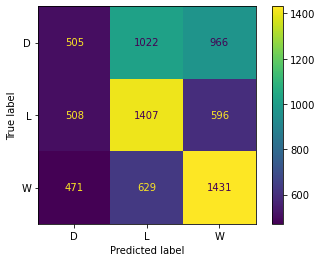

In [374]:
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 0.45
Mean accuracy on test set: 0.44


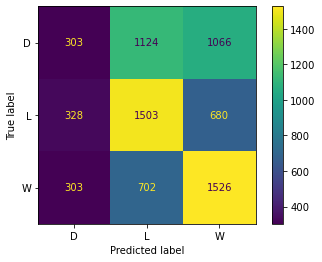

In [379]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 1.00
Mean accuracy on test set: 0.38


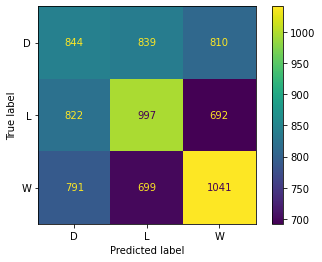

In [377]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

### Binary Classification (W/L)

In [411]:
H_x_binary = H_x[H_x['Results']!='D']

In [412]:
H_x_binary['Results'].value_counts()

W    13815
L     9134
Name: Results, dtype: int64

In [413]:
min_count = H_x_binary['Results'].value_counts().min()

H_x_binary_balanced = pd.DataFrame()
for cat in H_x_binary['Results'].unique():
    H_x_cat = H_x_binary[H_x_binary['Results']==cat].sample(min_count)
    H_x_binary_balanced = H_x_binary_balanced.append(H_x_cat)
    
H_x_binary_balanced.reset_index(drop=True, inplace=True)

H_y_binary_balanced = H_x_binary_balanced['Results']
H_x_binary_balanced = H_x_binary_balanced.drop(columns=['Results'])

In [415]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(H_x_binary_balanced, H_y_binary_balanced, test_size=0.33, random_state=42)

Mean accuracy on training set: 0.67
Mean accuracy on test set: 0.66


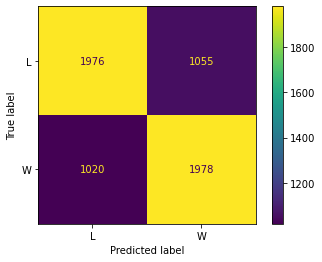

In [416]:
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 0.67
Mean accuracy on test set: 0.66


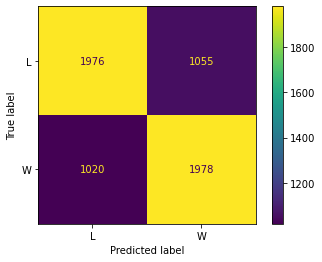

In [417]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

Mean accuracy on training set: 1.00
Mean accuracy on test set: 0.57


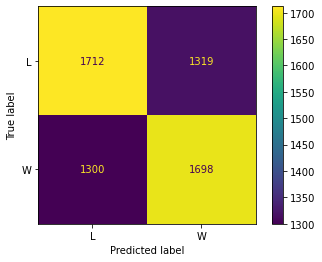

In [418]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

print('Mean accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Mean accuracy on test set: {:.2f}'.format(clf.score(X_test, y_test)))

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()